#### Created By: 
Iman sharifi --- 98210184

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Plot images
def _plot(img, title='image', figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(img, 'gray'), plt.title(title,fontsize = 18)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [27]:
# Read Images
def read_image():
    template = cv2.imread("HW4\\template.jpg")
    img = cv2.imread("HW4\\image.jpg")
    img1 = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img1,img2

## Plot Original Images

In [28]:
img1,img2 = read_image()

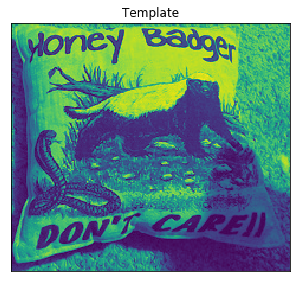

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

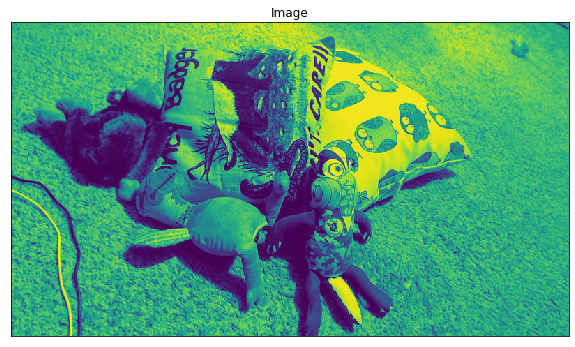

In [29]:
plt.figure(figsize=(5,5))
plt.imshow(img1),plt.title("Template")
plt.xticks([]), plt.yticks([]),plt.show()
plt.figure(figsize=(10,10))
plt.imshow(img2),plt.title("Image")
plt.xticks([]), plt.yticks([])

# SIFT Descriptor and Matching
There are mainly 4+1 steps involved in SIFT algorithm:
1. Scale-space Extrema Detection
2. Keypoint Localization
3. Orientation Assignment
4. Keypoint Descriptor
5. Keypoint Matching

Number of Detected Points: 619


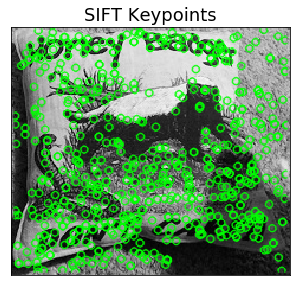

In [31]:
gray= img1
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,outImage=None, color=(0,255,0), flags=0)
print("Number of Detected Points:",len(kp))
_plot(img, 'SIFT Keypoints', (5,5))

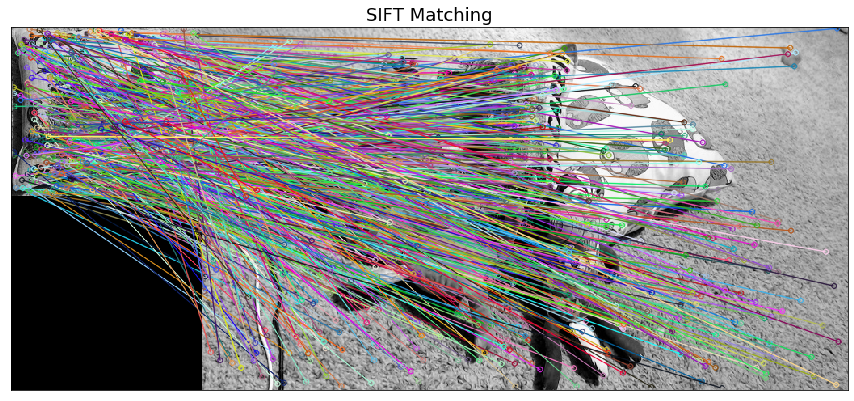

In [32]:
# create sift
sift = cv2.xfeatures2d.SIFT_create()

# find Keypoints of images
keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:], img2, flags=2)
_plot(img3, 'SIFT Matching', (15, 15))

### Brute-Force Matcher (BFMatcher)
Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance calculation. And the closest one is returned.

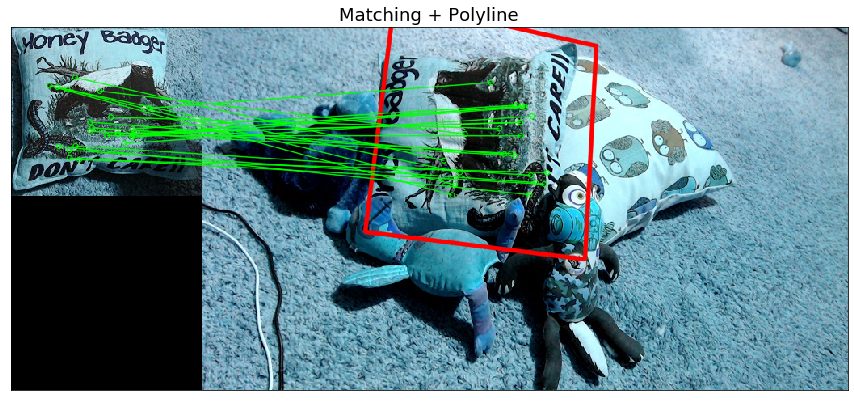

In [33]:
MIN_MATCH_COUNT = 10

# Read Images
img1 = cv2.imread("HW4\\template.jpg")
img2 = cv2.imread("HW4\\image.jpg")

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2) # returns k best matches 

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w,_ = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
_plot(img3, 'Matching + Polyline', (15, 15))

### FLANN based Matcher
FLANN stands for Fast Library for Approximate Nearest Neighbors. It contains a collection of algorithms optimized
for fast nearest neighbor search in large datasets and for high dimensional features. It works more faster than BFMatcher for large datasets.

### RANSAC Method
Random sample consensus (RANSAC) is an iterative method to estimate parameters of a mathematical model from a set of observed data that contains outliers, when outliers are to be accorded no influence on the values of the estimates. Therefore, it also can be interpreted as an outlier detection method.It is a non-deterministic algorithm in the sense that it produces a reasonable result only with a certain probability, with this probability increasing as more iterations are allowed. The algorithm was first published by Fischler and Bolles at SRI International in 1981. They used RANSAC to solve the Location Determination Problem (LDP), where the goal is to determine the points in the space that project onto an image into a set of landmarks with known locations. 

A basic assumption is that the data consists of "inliers", i.e., data whose distribution can be explained by some set of model parameters, though may be subject to noise, and "outliers" which are data that do not fit the model. The outliers can come, for example, from extreme values of the noise or from erroneous measurements or incorrect hypotheses about the interpretation of data. RANSAC also assumes that, given a (usually small) set of inliers, there exists a procedure which can estimate the parameters of a model that optimally explains or fits this data. 

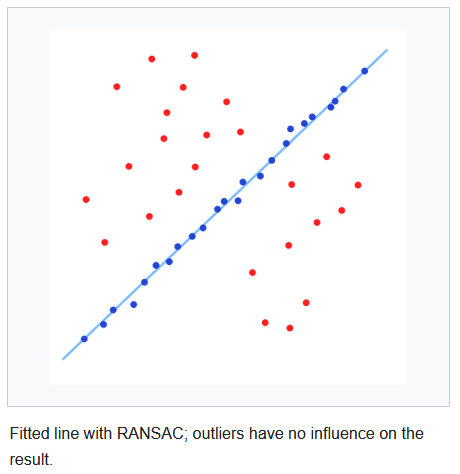

# ORB Descriptor and Matching

ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the
performance. First it use FAST to find keypoints, then apply Harris corner measure to find top N points among them.
It also use pyramid to produce multiscale-features. But one problem is that, FAST doesn’t compute the orientation.

It computes the intensity weighted centroid of the patch with located corner at center. The direction of the vector from this corner point to centroid gives the orientation. To improve the rotation invariance, moments are computed with x and y which should be in a circular region of radius 𝑟, where 𝑟 is the size of the patch.

Now for descriptors, ORB use BRIEF descriptors. But we have already seen that BRIEF performs poorly with rotation.
So what ORB does is to “steer” BRIEF according to the orientation of keypoints. For any feature set of 𝑛 binary tests at location (𝑥𝑖, 𝑦𝑖), define a 2 × 𝑛 matrix, 𝑆 which contains the coordinates of these pixels. Then using the orientation of patch, 𝜃, its rotation matrix is found and rotates the 𝑆 to get steered(rotated) version 𝑆𝜃.
ORB discretize the angle to increments of 2𝜋/30 (12 degrees), and construct a lookup table of precomputed BRIEF
patterns. As long as the keypoint orientation 𝜃 is consistent across views, the correct set of points 𝑆𝜃 will be used to compute its descriptor.

BRIEF has an important property that each bit feature has a large variance and a mean near 0.5. But once it is oriented along keypoint direction, it loses this property and become more distributed. High variance makes a feature more discriminative, since it responds differentially to inputs. Another desirable property is to have the tests uncorrelated, since then each test will contribute to the result. To resolve all these, ORB runs a greedy search among all possible binary tests to find the ones that have both high variance and means close to 0.5, as well as being uncorrelated. The result is called rBRIEF.

In [34]:
img1,img2 = read_image()

Number of Detected Points: 416


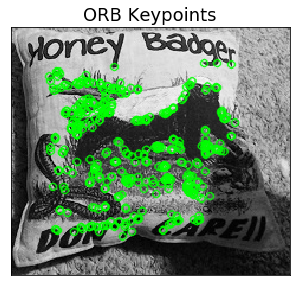

In [35]:
# Initiate STAR detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp = orb.detect(img1,None)
# compute the descriptors with ORB
kp, des = orb.compute(img1, kp)
# draw only keypoints location,not size and orientation
img1_ = cv2.drawKeypoints(img1,kp, outImage=None, color=(0,255,0), flags=0)
print("Number of Detected Points:",len(kp))
_plot(img1_,'ORB Keypoints',(5,5))

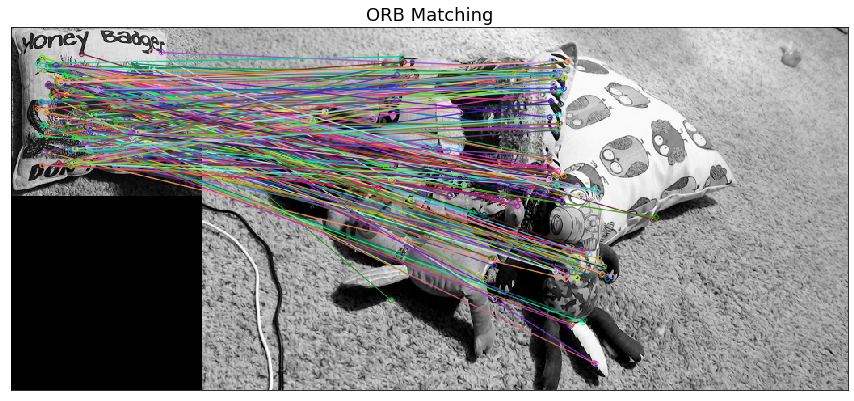

In [36]:
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:],None, flags=2)
_plot(img3, 'ORB Matching', (15,15))

# Surf Descriptor (Extra part)

In SIFT, Lowe approximated Laplacian of Gaussian with Difference of Gaussian for finding scale-space. SURF goes
a little further and approximates LoG with Box Filter. Below image shows a demonstration of such an approximation.
One big advantage of this approximation is that, convolution with box filter can be easily calculated with the help of integral images. And it can be done in parallel for different scales. Also the SURF rely on determinant of Hessian matrix for both scale and location.

In short, SURF adds a lot of features to improve the speed in every step. Analysis shows it is 3 times faster than SIFT while performance is comparable to SIFT. SURF is good at handling images with blurring and rotation, but not good at handling viewpoint change and illumination change.

In [37]:
img1,img2 = read_image()

Number of Detected Points: 532


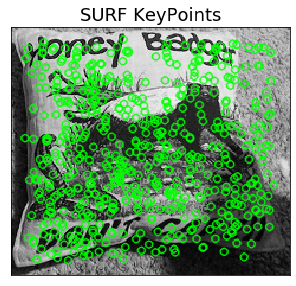

In [39]:
gray1 = img1

# Surf
surf = cv2.xfeatures2d.SURF_create()
#keypoints
keypoints_1, descriptors_1 = surf.detectAndCompute(img1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1, color=(0,255,0), flags=0)
print("Number of Detected Points:",len(keypoints_1))
_plot(img_1, 'SURF KeyPoints', (5,5))

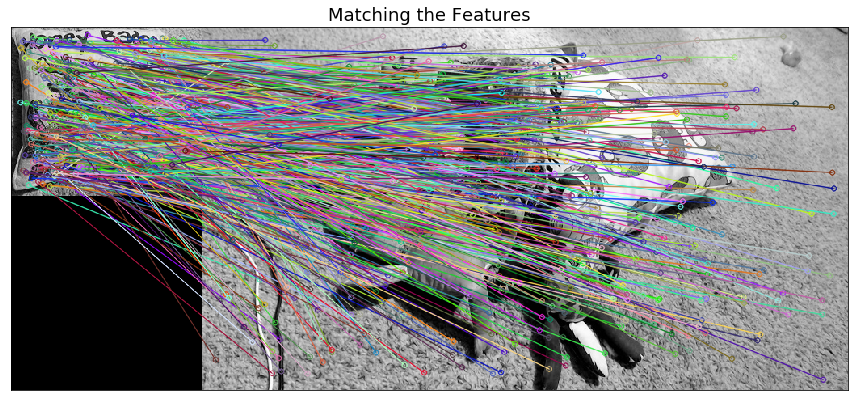

In [40]:
#surf
surf = cv2.xfeatures2d.SURF_create()

keypoints_1, descriptors_1 = surf.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = surf.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1,keypoints_1,img2,keypoints_2,matches[:],img2,flags=2)
_plot(img3, 'Matching the Features', (15, 15))

# Comparison of Algorithms
Number of Detected Points ---> SIFT:619, ORB:416, SURF:532

SIFT find number of detected poins more than other algorithms.

Also SIFT Match is better than the other in this template and image.

The papers says ORB is much faster than SURF and SIFT and ORB descriptor works better than SURF. ORB is a good choice in low-power devices for panorama stitching etc.